# Import libraries

In [36]:
import re 
from typing import List, Dict, Optional
import numpy as np
from PIL import Image
import pytesseract
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json

# Bank Classification Function

In [37]:
def classify_bank(image_path: str, model, class_indices) -> str:
    if model is None:
        print("Bank classfication model not loaded. Returning 'Unknown'.")
        return "Unknown"
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_bank = class_indices[predicted_class_index]
        confidence = predictions[0][predicted_class_index]
        
        print(f"Predicted bank: {predicted_bank} with confidence: {confidence:.2f}")
        return predicted_bank
    except Exception as e:
        print(f"Error during bank classification: {e}")
        return "Unknown"

# Image Preprocessing

In [40]:
def preprocess_image(image_path):
    """
    Specialized preprocessing for mobile transaction receipts.
    """
    # Load and get initial image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Handle dark/light themes
    mean_intensity = np.mean(gray)
    if mean_intensity < 127:
        # Invert dark theme to light
        gray = cv2.bitwise_not(gray)
    
    # Enhance text using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Denoise while preserving text edges
    denoised = cv2.fastNlMeansDenoising(enhanced)
    
    # Improve contrast
    alpha = 1.5  # Contrast control
    beta = 10    # Brightness control
    adjusted = cv2.convertScaleAbs(denoised, alpha=alpha, beta=beta)
    
    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(
        adjusted,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        21,
        11
    )
    
    # Scale up for better OCR
    scale_factor = 1.5
    scaled = cv2.resize(binary, None, fx=scale_factor, fy=scale_factor, 
                       interpolation=cv2.INTER_CUBIC)
    
    return scaled

# Data Extraction Function

In [42]:
def extract_data(image, bank_type="ABA") -> dict:
    """
    Extracts transaction data from a preprocessed image of an ABA or ACLIDA Bank receipt.
    
    Parameters:
    - image (numpy array): Input image.
    - bank_type (str): "ABA" or "ACLIDA" to specify the bank.
    
    Returns:
    - dict: Extracted data with keys 'transaction_id', 'amount', 'date'.
    """
    # Step 1: Preprocess the image
    processed_image = preprocess_image(image)
    
    # Step 2: Configure Tesseract OCR with multilingual support
    custom_config = r'--oem 3 --psm 6 -l eng+tha+khm'
    extracted_text = pytesseract.image_to_string(processed_image, config=custom_config)
    
    # Step 3: Clean up the extracted text
    extracted_text = extracted_text.strip()
    extracted_text = re.sub(r'\s+', ' ', extracted_text)
    extracted_text = re.sub(r'[^\w\s\d\.\-\/:\u1780-\u17FF]', '', extracted_text)
    
    # Step 4: Define patterns based on bank type with improved flexibility
    if bank_type == "ABA":
        pattern = {
            "transaction_id": r"(?:Trx\.?|Transaction|លេខប្រតិបត្តិការ)\s*(?:ID|1D)?\s*[:\s]*(\d+)",
            "amount": r"-?\d{1,3}\.?\d{0,2}\s*USD",  # Allow variable decimal places
            "date": r"(?:Transaction\s*date|Date|កាលបរិច្ឆេទ)\s*[:\s]*([A-Za-z]+\s*\d{1,2}\s*[, ]*\d{4}\s*\d{1,2}:\d{2}\s*[AP]?M?)"
        }
        fallback_amount = r"-?\d{1,3}\.?\d{0,2}\s*(?:USD|SAND\s*BAKERY)"
    elif bank_type == "ACLIDA":
        pattern = {
            "transaction_id": r"(?:Transaction\s*No\.?|លេខប្រតិបត្តិការ)\s*[:\s]*(\d+)",
            "amount": r"(?:Amount|ចំនួនទឹកប្រាក់)\s*[:\s]*(-?\d{1,3}\.?\d{0,2})",
            "date": r"(?:Date|កាលបរិច្ឆេទ)\s*[:\s]*(\d{4}[-\d{2}]*\s*\d{2}:\d{2}[:\d{2}]*)"
        }
        fallback_amount = r"-?\d{1,3}\.?\d{0,2}"
    else:
        raise ValueError("Bank type must be 'ABA' or 'ACLIDA'")
    
    extracted_data = {}
    
    # Step 5: Extract data with regex
    for key, regex in pattern.items():
        match = re.search(regex, extracted_text, re.IGNORECASE | re.UNICODE)
        
        if match:
            if key == "transaction_id":
                extracted_data[key] = match.group(1)
            elif key == "amount":
                amount_str = re.search(r"-?\d{1,3}\.?\d{0,2}", match.group(0))
                extracted_data[key] = float(amount_str.group(0)) if amount_str else "None"
            elif key == "date":
                extracted_data[key] = match.group(1).strip()
        else:
            if key == "amount":
                match_fallback = re.search(fallback_amount, extracted_text, re.IGNORECASE | re.UNICODE)
                if match_fallback:
                    amount_str = re.search(r"-?\d{1,3}\.?\d{0,2}", match_fallback.group(0))
                    extracted_data[key] = float(amount_str.group(0)) if amount_str else "None"
                else:
                    extracted_data[key] = "None"
            else:
                extracted_data[key] = "None"
    
    return extracted_data

In [44]:
def extract_all_text(image):
    """
    Extracts all text from a preprocessed image.
    
    Parameters:
    - image (numpy array or str): Input image or image path.
    
    Returns:
    - str: Extracted text.
    """
    if isinstance(image, str):
        processed_image = preprocess_image(image)
    else:
        processed_image = image
    
    # Configure Tesseract OCR with multilingual support
    custom_config = r'--oem 3 --psm 6 -l eng+tha+khm'
    extracted_text = pytesseract.image_to_string(processed_image, config=custom_config)
    
    # Clean up the extracted text
    extracted_text = extracted_text.strip()
    extracted_text = re.sub(r'\s+', ' ', extracted_text)
    extracted_text = re.sub(r'[^\w\s\d\.\-\/:\u1780-\u17FF]', '', extracted_text)
    
    return extracted_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00


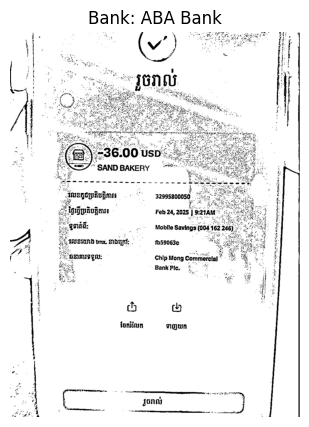

Extracted Text:
 in Soe Zé a t 7 hae BR mr  nga SES ES Ea soy is SE eS te SHS : at SL eB e et fi 6 PIAS eg bee eae woe th CEM ee STI Fae eR AE .. yy Bist gpa SOM Eg Tee LG 4 Ee Tee rere alee St :éM Bi Ake ae Dae : Ae eat prciey MGA Sy. . a Poe SAND BAKERY Pda URS ee : Muagepnugmis . 329958000580 Vase TK ey e pee BO aL Searels ce AGG AUR MIE Feb 24 2025  9:27AM iy-letieess ee _  Mobile Savings 004 162 246: Fas f pg 7h BEUS GO Chip Mong Commerelal  se we  : oes ank Pee oe ae OE  i on Grin Mawr  wv . at : Weweereee 8 . w cad id TTI 2 Zi ap Ne ny . 1 7 a4 Jonas core gl x  A Titian cas   ms
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted bank: ABA Bank with confidence: 1.00


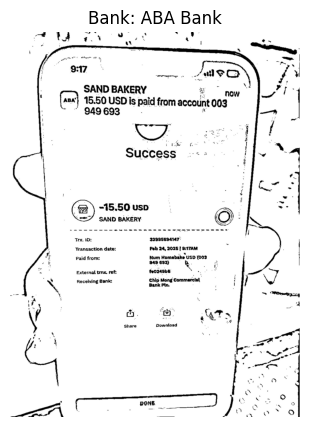

Extracted Text:
 en 5 en  y M7 ee Lae f   SAND BAKERY ee eae aon 15.50 USD is paid from account 003   gag693    Success - j v A  i Cail . 15.50usD a .-  ss Nawess/ SAND BAKERY.  IX  fi Transaction date: Feb 24 2025  9177AM  .  4 Paid feom: Num Homebaks USD 008  x : External tnx ref: feoasabe  . -  2 . .  Receiving Banic Chie Mond Commercial  :  wi 1 . es 4 Share Download a  . yy ee ie ire wa 7 ao   a  .   oo mS sy o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted bank: ABA Bank with confidence: 1.00


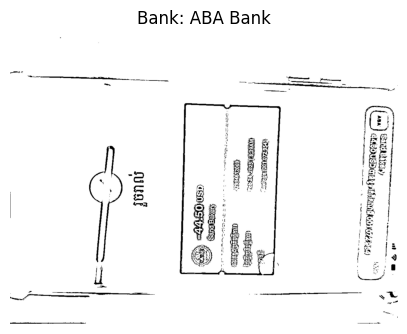

Extracted Text:
   gg re Ce  Ni
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted bank: ABA Bank with confidence: 1.00


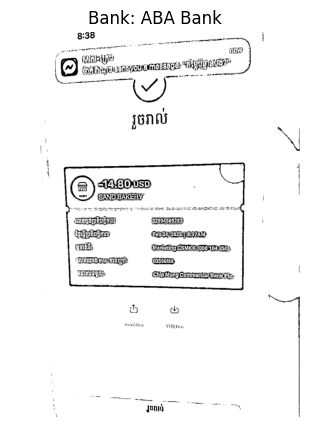

Extracted Text:
  spugynocaio aunties THEE . a  ion .  Lee a ea iacdiltirs MAUiA gon 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted bank: ABA Bank with confidence: 1.00


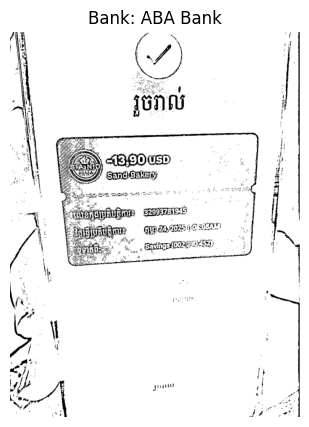

Extracted Text:
 : il 4 Te  We Y   _ Sen  S Nc Saker ya er irs . ROBIE Ie GEARS  f oo Pot sp he yeaa i  : : i  4 ra . a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted bank: ABA Bank with confidence: 1.00


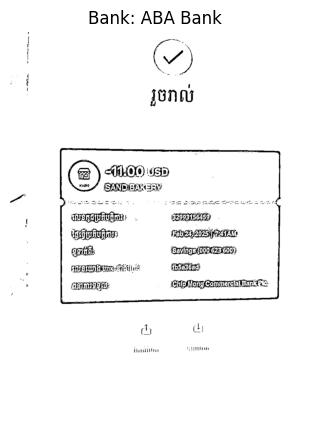

Extracted Text:
    jon  Beret Ae ey me  TREMRI: a ETERS Bp chia Mong commerciaL Bank Diam an chy iismrditines Ce eydtade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted bank: ABA Bank with confidence: 1.00


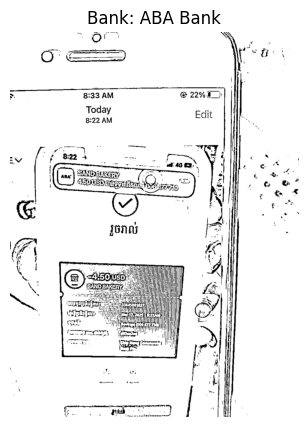

Extracted Text:
  4 7  8:33 AM  228_ Today . 8:27 AM Eciit me _. -  8:22 4. . to oF Es es : ene Med azen  ye ave jonas   _ NO fs 7 4 t  a it os  -   Sad   :
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted bank: ACLIDA Bank with confidence: 1.00


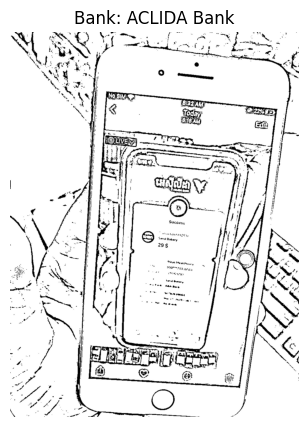

Extracted Text:
 why aaa 5 e aes eae Sf Sef    a:  pink __ ik  if  .  ./ Eee  eS 1a  at ry  YL - f.   af 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted bank: ABA Bank with confidence: 1.00


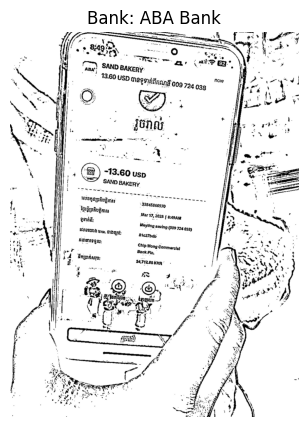

Extracted Text:
  aan SAND BAKERY: now 2 we  13.60 USD memrétisnns O09 794 03g t 4 wo  .  if - - ST fon  oe 13.60 usp an  tke SAND BakERy  yo .  Wongng go TTT Etteeee eee. f  e t  aa  age pRufimins  33848age979  ie eat  MT Tadpiogine Mar 172005  saga  Poo a . . i ena Mevting saving 009 724038 ff. oe eS t woe h  ivatand tmx snp 81c27pab 7 ow ww of. . 7 i age  Ssenre ges: Chip Mong Commerctat  A ra we oe eee  Laer Bank Plo _ ASS ay ey. ik  0 Sanieon S7Re0kHR:  gs ee    thy x _ Bess AL ba Aly ge in... en ek rn  AA 4 eres wy f wat SSE VL ay a oi e  Ca : vy ys .  4 fe yo tos y . wen to
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted bank: ABA Bank with confidence: 1.00


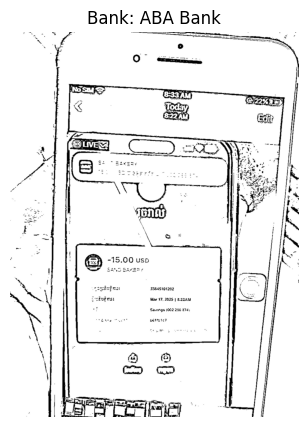

Extracted Text:
 . se  oh _ a . .  L  a if pe 233. ee é : ee .  ay    f iy BEE ns  - i .   Po  4  K : a -15.00 usp Bt ce . .     s4ncesvesy ip i . sw pukurms Mas 7 2025  2:22A4  F Sanngs 1652 226 174  tbe tee CAV teT    
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted bank: ABA Bank with confidence: 1.00


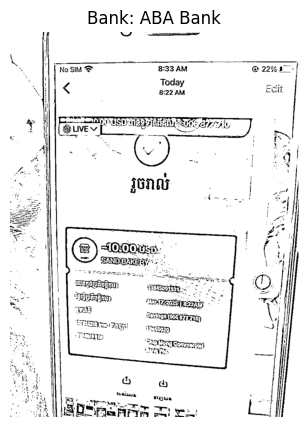

Extracted Text:
 . A  .  xo sin  8:33 AM  2287  an  Today ao. of Nf  8:22 AM call ae nT. UIUS Ola SY SiknaENOUgs cag tO . i i: : ie J Ye a  m0.00USo am   7 a  sym TEED eee fi wy F
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted bank: ABA Bank with confidence: 1.00


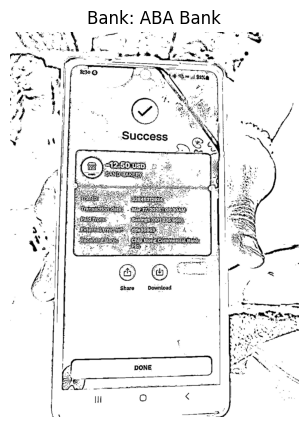

Extracted Text:
 Ne Og WO OM x. oo oT re Sed i. Be yee 5   ae poe ch . a oo yf  o _ ip x20 La Wye i  Se  4 Ut ON SB Ah  B2m Ae eo  as ION.   ee ae Teg Be / Y wif  Success gW  / 7 ae f1250 USD . o. RY an Oe eoction cate ae var 172028  ca:s0ANg   Ry    eee. aero Ys re i re Fexrernal Pierre pe dacseucs Paheeti se A SRESS  Bccure cieearcne wore conmercs es ila Is ai f on 77.  _ Share Download f oe .  . a : _ x . wos 7 a ys es ares ee y aeyelS al  Re ne ie D  7 Proll Wl O   ol on  ____ fp


In [47]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES =["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/chettra_test/"

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', 'jpeg', 'PNG'))]

all_text = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    preprocessed_image = preprocess_image(image_path)
    extracted_text = extract_all_text(image_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    print(f"Extracted Text:\n {extracted_text}")
    
    all_text.append(extracted_text)

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00


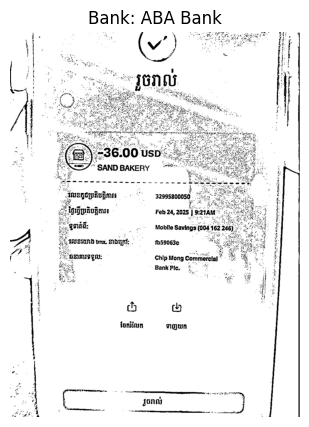

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted bank: ABA Bank with confidence: 1.00


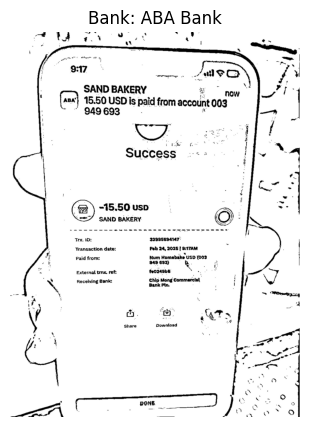

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": 15.5,
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted bank: ABA Bank with confidence: 1.00


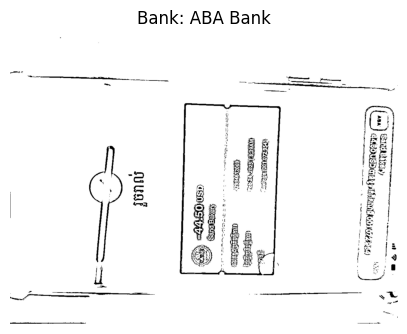

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted bank: ABA Bank with confidence: 1.00


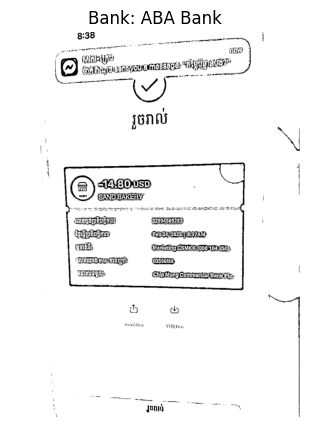

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted bank: ABA Bank with confidence: 1.00


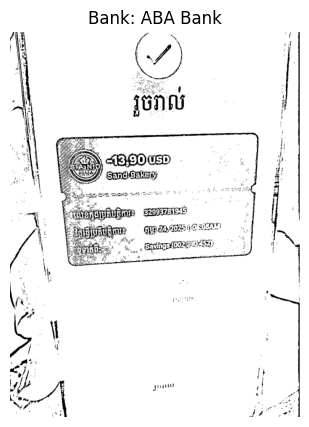

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted bank: ABA Bank with confidence: 1.00


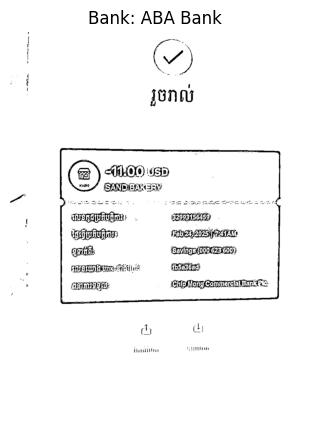

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted bank: ABA Bank with confidence: 1.00


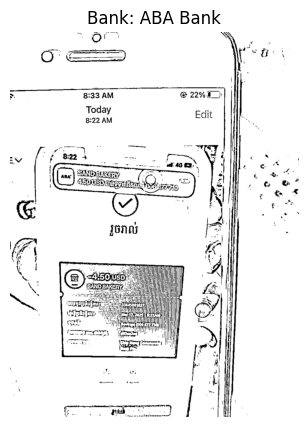

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted bank: ACLIDA Bank with confidence: 1.00


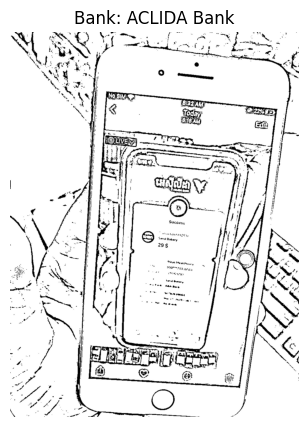

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted bank: ABA Bank with confidence: 1.00


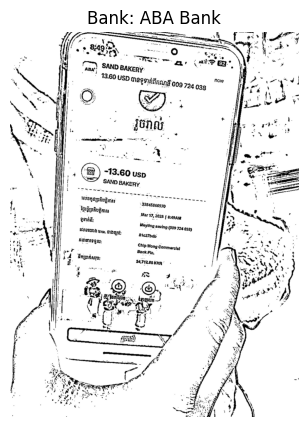

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": 13.6,
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted bank: ABA Bank with confidence: 1.00


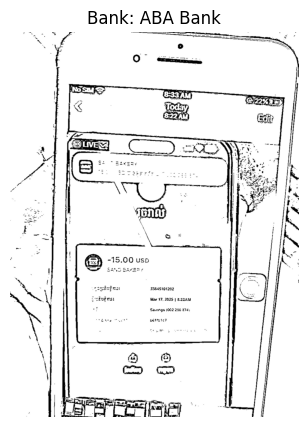

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted bank: ABA Bank with confidence: 1.00


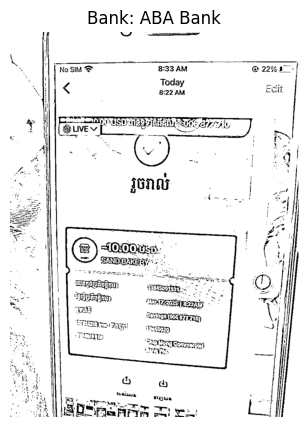

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted bank: ABA Bank with confidence: 1.00


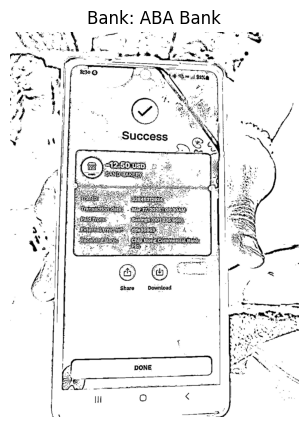

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": 1250.0,
  "date": "None"
}


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES =["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/chettra_test/"

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', 'jpeg', 'PNG'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    preprocessed_image = preprocess_image(image_path)
    if classified_image == "ABA Bank":
        extracted_data = extract_data(image_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    print(f"Extracted Transaction Data:\n {json.dumps(extracted_data, indent=2)}")
    
    amount.append(extracted_data['amount'])

print(f"Total amount: {sum(amount)}")